In [1]:
import string

import eli5
import hdbscan
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import shap
import tensorflow as tf
import tensorflow_addons as tfa
import torch
import torch.nn as nn
from captum.attr import IntegratedGradients, LayerConductance, NeuronConductance
from eli5.sklearn import PermutationImportance
from scipy import stats
from scipy.optimize import minimize
from sklearn.cluster import MeanShift, estimate_bandwidth
from sklearn.datasets import make_regression
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.inspection import permutation_importance
from sklearn.metrics import *
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers
from tensorflow.keras.models import load_model
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier, KerasRegressor

from optimizer import Lookahead
from radam import RAdam

plt.style.use("seaborn-pastel")
%matplotlib inline


shap.initjs()

/Users/divishrengasamy/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.metrics.scorer module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)
/Users/divishrengasamy/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.feature_selection.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.feature_selection. Anything that cannot be imported from sklearn.feature_selection is now part of the private API.
  warnings.warn(message, FutureWarning)
Using TensorFlow backend.


In [2]:
FEATS = 20
features, output, coef = make_regression(
    n_samples=1000,
    # three features
    n_features=FEATS,
    # where only two features are useful,
    n_informative=15,
    # a single target value per observation
    n_targets=1,
    # 0.0 standard deviation of the guassian noise
    noise=0.1,
    # show the true coefficient used to generated the data
    coef=True,
)

In [3]:
coef

array([97.51062756, 68.65268444, 74.31157233, 80.83624806, 26.95593051,
        0.        ,  0.        , 72.8354393 ,  0.        , 65.53766341,
        0.        , 31.0092232 , 49.61576437, 59.03894671,  0.        ,
       57.02709186, 21.64087442, 55.2996804 , 56.92025657,  8.25344133])

In [4]:
scaled_coef = (coef - coef.min()) / (coef.max() - coef.min())

In [5]:
alphabet_list = list(string.ascii_lowercase)
column_names = np.array(alphabet_list[0:FEATS])
df_features = pd.DataFrame(features, columns=column_names)

In [6]:
df_output = pd.DataFrame(output, columns=["output"])

In [7]:
X_train, X_test, y_train, y_test = train_test_split(features, output, test_size=0.2, shuffle=True, random_state=42)

In [8]:
def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100


mae_scorer = make_scorer(mean_absolute_error, greater_is_better=False)

In [9]:
rf_regr = RandomForestRegressor(max_depth=7, n_estimators=700)
rf_regr.fit(X_train, y_train)
rf_predicted = rf_regr.predict(X_test)

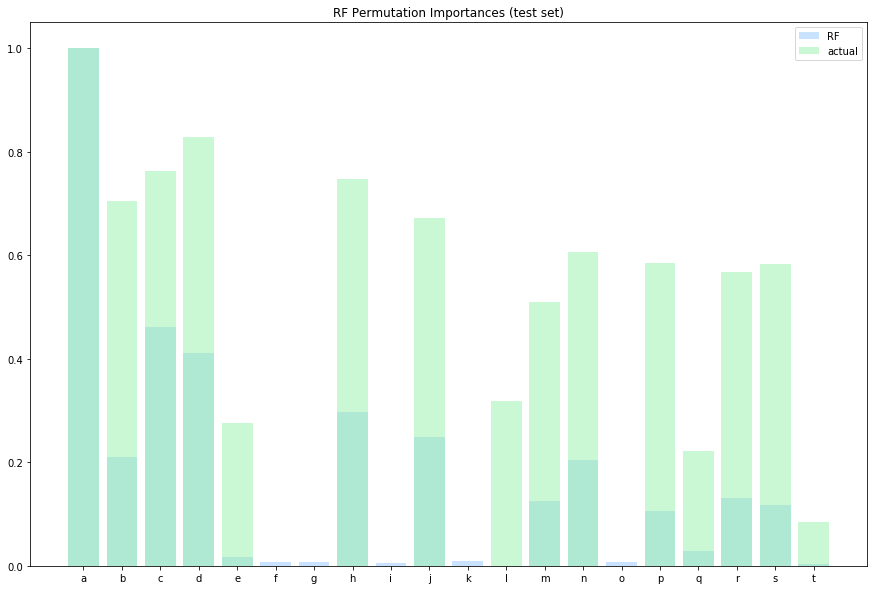

In [10]:
pi_result_rf = permutation_importance(rf_regr, X_test, y_test, n_repeats=10, random_state=42, scoring=mae_scorer)


pi_result_rf_scaled = (pi_result_rf.importances_mean - pi_result_rf.importances_mean.min()) / (
    pi_result_rf.importances_mean.max() - pi_result_rf.importances_mean.min()
)
pos = np.arange(column_names.size)
plt.figure(figsize=(15, 10))
plt.bar(pos, pi_result_rf_scaled, align="center", alpha=0.5, label="RF")
plt.bar(pos, scaled_coef, align="center", alpha=0.5, label="actual")
plt.xticks(pos, column_names)
plt.title("RF Permutation Importances (test set)")
plt.legend(loc="best")
plt.show()

In [11]:
gb_regr = GradientBoostingRegressor(max_depth=5, n_estimators=500)
gb_regr.fit(X_train, y_train)
gb_predicted = gb_regr.predict(X_test)

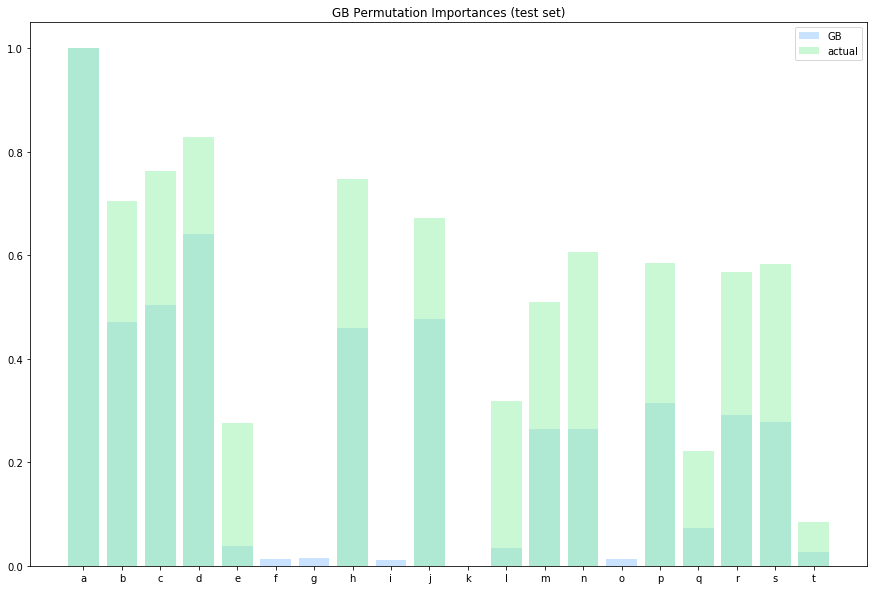

In [12]:
pi_result_gb = permutation_importance(gb_regr, X_test, y_test, n_repeats=10, random_state=42, scoring=mae_scorer)

pi_result_gb_scaled = (pi_result_gb.importances_mean - pi_result_gb.importances_mean.min()) / (
    pi_result_gb.importances_mean.max() - pi_result_gb.importances_mean.min()
)
pos = np.arange(column_names.size)
plt.figure(figsize=(15, 10))
plt.bar(pos, pi_result_gb_scaled, align="center", alpha=0.5, label="GB")
plt.bar(pos, scaled_coef, align="center", alpha=0.5, label="actual")
plt.xticks(pos, column_names)
plt.title("GB Permutation Importances (test set)")
# plt.xticks(rotation=90)
plt.legend(loc="best")
plt.show()

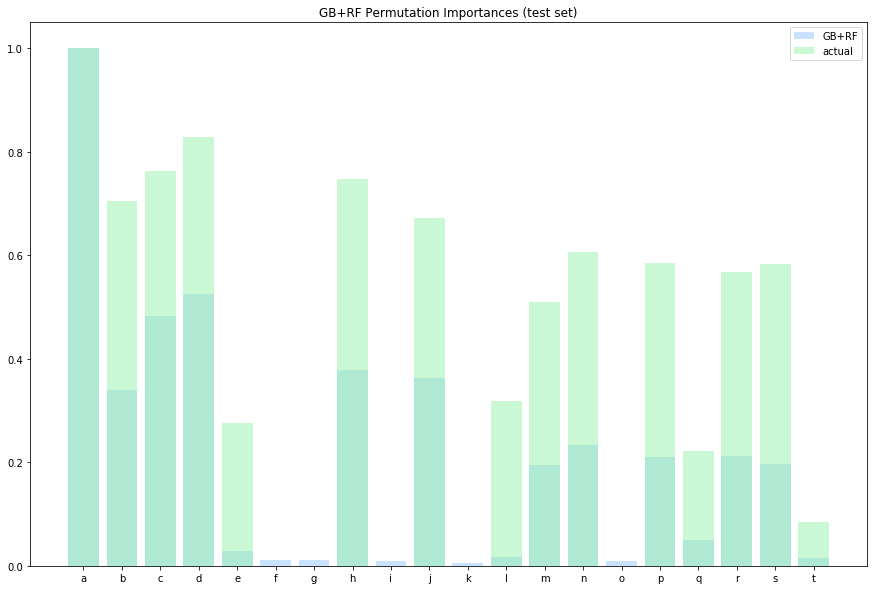

In [13]:
pos = np.arange(column_names.size)
plt.figure(figsize=(15, 10))
plt.bar(
    pos, (pi_result_gb_scaled + pi_result_rf_scaled) / 2, align="center", alpha=0.5, label="GB+RF",
)
plt.bar(pos, scaled_coef, align="center", alpha=0.5, label="actual")
plt.xticks(pos, column_names)
plt.title("GB+RF Permutation Importances (test set)")
# plt.xticks(rotation=90)
plt.legend(loc="best")
plt.show()

In [14]:
print(f"GB predicted error: {np.abs(gb_predicted - y_test).mean()}")

GB predicted error: 80.6051627057285


In [15]:
print(f"RF predicted error: {np.abs(rf_predicted - y_test).mean()}")

RF predicted error: 108.884851291904


In [16]:
print(f"RF PI error: {np.abs(pi_result_rf_scaled - scaled_coef).mean()}")
print(f"GB PI error: {np.abs(pi_result_gb_scaled - scaled_coef).mean()}")
print(f"RF+GB PI error: {np.abs(((pi_result_gb_scaled+pi_result_rf_scaled)/2) - scaled_coef).mean()}")

RF PI error: 0.25716946993322054
GB PI error: 0.1690968025060642
RF+GB PI error: 0.21313313621964233


In [17]:
explainer_rf = shap.TreeExplainer(rf_regr)
shap_values_rf = explainer_rf.shap_values(df_features)

explainer_gb = shap.TreeExplainer(gb_regr)
shap_values_gb = explainer_gb.shap_values(df_features)

Setting feature_perturbation = "tree_path_dependent" because no background data was given.
The sklearn.ensemble.gradient_boosting module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.ensemble. Anything that cannot be imported from sklearn.ensemble is now part of the private API.


In [18]:
gb_sv = np.abs(shap_values_gb).mean(0)
gb_sv_min = np.abs(shap_values_gb).mean(0).min()
gb_sv_max = np.abs(shap_values_gb).mean(0).max()

gb_sv_scaled = (gb_sv - gb_sv_min) / (gb_sv_max - gb_sv_min)


rf_sv = np.abs(shap_values_rf).mean(0)
rf_sv_min = np.abs(shap_values_rf).mean(0).min()
rf_sv_max = np.abs(shap_values_rf).mean(0).max()

rf_sv_scaled = (rf_sv - rf_sv_min) / (rf_sv_max - rf_sv_min)

In [19]:
print(f"RF SV error: {np.abs(rf_sv_scaled - scaled_coef).mean()}")
print(f"GB SV error: {np.abs(gb_sv_scaled - scaled_coef).mean()}")
print(f"RF+GB SV error: {np.abs(((gb_sv_scaled+rf_sv_scaled)/2) - scaled_coef).mean()}")
print("")
print(f"GB PI error: {np.abs(pi_result_gb_scaled - scaled_coef).mean()}")
print(f"GB SV error: {np.abs(gb_sv_scaled - scaled_coef).mean()}")
print(f"GB PI + GB SV error: {np.abs(((gb_sv_scaled+pi_result_gb_scaled)/2) - scaled_coef).mean()}")
print("")
print(f"RF PI error: {np.abs(pi_result_rf_scaled - scaled_coef).mean()}")
print(f"RF SV error: {np.abs(rf_sv_scaled - scaled_coef).mean()}")
print(f"RF PI + RF SV error: {np.abs(((rf_sv_scaled+pi_result_rf_scaled)/2) - scaled_coef).mean()}")
print("")
total_pi_sv_scaled = (rf_sv_scaled + pi_result_rf_scaled + gb_sv_scaled + pi_result_gb_scaled) / 4
print(f"(RF PI + RF SV) + (GB PI + GB SV) error: {np.abs(total_pi_sv_scaled - scaled_coef).mean()}")

RF SV error: 0.1973364550830158
GB SV error: 0.09437086790545798
RF+GB SV error: 0.14585366149423692

GB PI error: 0.1690968025060642
GB SV error: 0.09437086790545798
GB PI + GB SV error: 0.1317338352057611

RF PI error: 0.25716946993322054
RF SV error: 0.1973364550830158
RF PI + RF SV error: 0.2272529625081181

(RF PI + RF SV) + (GB PI + GB SV) error: 0.17949339885693966


# DNN

In [20]:
y_test.shape

(200,)

In [21]:
class SimpleNNModel(nn.Module):
    def __init__(self):
        super().__init__()
        #         self.linear1 = nn.Linear(20, 128)
        #         self.relu1 = nn.ReLU()

        #         self.linear2 = nn.Linear(128, 256)
        #         self.relu2 = nn.ReLU()

        #         self.linear3 = nn.Linear(256, 128)
        #         self.relu3 = nn.ReLU()

        #         self.linear4 = nn.Linear(128, 64)
        #         self.relu4 = nn.ReLU()

        self.linear5 = nn.Linear(FEATS, 64)
        self.relu5 = nn.Tanh()

        self.linear6 = nn.Linear(64, 32)
        self.relu6 = nn.Tanh()

        self.linear7 = nn.Linear(32, 16)
        self.relu7 = nn.Tanh()

        self.linear8 = nn.Linear(16, 8)
        self.relu8 = nn.Tanh()

        self.linear9 = nn.Linear(8, 6)
        self.relu9 = nn.Tanh()

        self.linear10 = nn.Linear(6, 4)
        self.relu10 = nn.Tanh()

        self.linear11 = nn.Linear(4, 1)
        # self.relu11 = nn.ReLU()

    def forward(self, x):
        #         x = self.relu1(self.linear1(x))
        #         x = self.relu2(self.linear2(x))
        #         x = self.relu3(self.linear3(x))
        #         x = self.relu4(self.linear4(x))
        x = self.relu5(self.linear5(x))
        x = self.relu6(self.linear6(x))
        x = self.relu7(self.linear7(x))
        x = self.relu8(self.linear8(x))
        x = self.relu9(self.linear9(x))
        x = self.relu10(self.linear10(x))
        x = self.linear11(x)
        return x


from optimizer import Lookahead
from radam import RAdam

y_train = np.reshape(y_train, (y_train.shape[0], 1))
y_test = np.reshape(y_test, (y_test.shape[0], 1))
net = SimpleNNModel()


def init_weights(m):
    if type(m) == nn.Linear:
        torch.nn.init.xavier_uniform_(m.weight)
        m.bias.data.fill_(0.01)


net.apply(init_weights)

USE_PRETRAINED_MODEL = False
n_batches = 32
if USE_PRETRAINED_MODEL:
    net.load_state_dict(torch.load("interpret_model.pt"))
    print("Model Loaded!")
else:
    criterion = nn.MSELoss()
    num_epochs = 1000

    # optimizer = torch.optim.AdamW(net.parameters(), lr=0.0003, weight_decay=0.01)
    base_optim = RAdam(net.parameters(), lr=0.01)
    optimizer = Lookahead(base_optim, k=6, alpha=0.5)
    input_tensor = torch.from_numpy(X_train).type(torch.FloatTensor)
    label_tensor = torch.from_numpy(y_train).type(torch.FloatTensor)
    for epoch in range(num_epochs):
        for i in range(n_batches):
            local_X, local_y = (
                input_tensor[i * n_batches : (i + 1) * n_batches,],
                label_tensor[i * n_batches : (i + 1) * n_batches,],
            )
            output = net(input_tensor)
            loss = criterion(output, label_tensor)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        if epoch % 100 == 0:
            print("Epoch {}/{} => Loss: {:.6f}".format(epoch + 1, num_epochs, loss.item()))

    torch.save(net.state_dict(), "interpret_model.pt")

Epoch 1/1000 => Loss: 53166.234375
Epoch 101/1000 => Loss: 38052.421875
Epoch 201/1000 => Loss: 25027.957031
Epoch 301/1000 => Loss: 15930.054688
Epoch 401/1000 => Loss: 9995.837891
Epoch 501/1000 => Loss: 6103.428223
Epoch 601/1000 => Loss: 3685.511230
Epoch 701/1000 => Loss: 2187.158691
Epoch 801/1000 => Loss: 1397.906616
Epoch 901/1000 => Loss: 836.781189


In [22]:
test_input_tensor = torch.from_numpy(X_test).type(torch.FloatTensor)
test_output = net(test_input_tensor).detach().numpy()
print("Test MSE:", np.sqrt((np.abs(test_output - y_test)).mean()))

Test MSE: 6.293643939456603


In [23]:
ig = IntegratedGradients(net)
test_input_tensor = torch.from_numpy(X_train).type(torch.FloatTensor)
test_input_tensor.requires_grad_()
attr, delta = ig.attribute(test_input_tensor, return_convergence_delta=True)
attr = attr.detach().numpy()

feature_names = list(column_names)

Intergrated Gradient Average Feature Importances
a :  -12.826
b :  51.431
c :  -19.029
d :  -5.157
e :  39.807
f :  -27.959
g :  5.008
h :  -5.606
i :  44.351
j :  -41.784
k :  -31.855
l :  14.001
m :  -12.235
n :  -41.262
o :  12.220
p :  22.134
q :  -17.822
r :  25.578
s :  -17.244
t :  -4.830


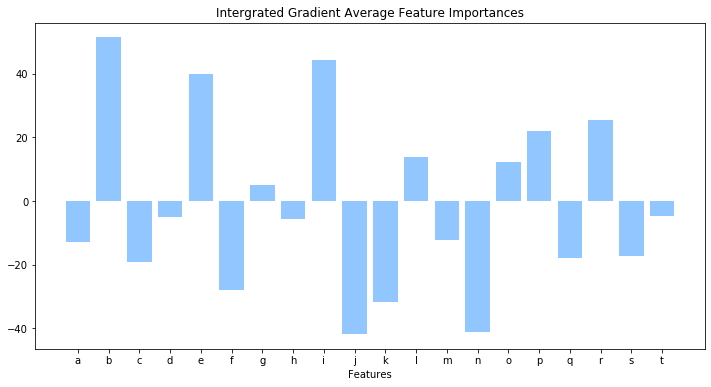

In [24]:
def visualize_importances(
    feature_names,
    importances,
    title="Intergrated Gradient Average Feature Importances",
    plot=True,
    axis_title="Features",
):
    print(title)
    for i in range(len(feature_names)):
        print(feature_names[i], ": ", "%.3f" % (importances[i]))
    x_pos = np.arange(len(feature_names))
    if plot:
        plt.figure(figsize=(12, 6))
        plt.bar(x_pos, importances, align="center")
        plt.xticks(x_pos, feature_names, wrap=False)
        plt.xlabel(axis_title)
        plt.title(title)


visualize_importances(column_names, np.mean(attr, axis=0))

In [25]:
dnn_ig = np.abs(np.mean(attr, axis=0))
dnn_ig = np.abs(dnn_ig)
dnn_ig_min = np.abs(dnn_ig).min()
dnn_ig_max = np.abs(dnn_ig).max()

dnn_ig_scaled = (dnn_ig - dnn_ig_min) / (dnn_ig_max - dnn_ig_min)
dnn_ig_scaled

array([0.17158696, 1.        , 0.3046863 , 0.00701967, 0.7505612 ,
       0.4963179 , 0.00382205, 0.01664728, 0.8480745 , 0.7929894 ,
       0.5799235 , 0.19680636, 0.15890288, 0.7817839 , 0.15858003,
       0.3713221 , 0.27878672, 0.445226  , 0.2663886 , 0.        ],
      dtype=float32)

In [26]:
print(f"DNN IG error: {np.abs(dnn_ig_scaled - scaled_coef).mean()}")
# print(f'RF SV error: {np.abs(rf_sv_scaled - scaled_coef).mean()}')
# print(f'RF PI + RF SV error: {np.abs(((rf_sv_scaled+pi_result_rf_scaled)/2) - scaled_coef).mean()}')

DNN IG error: 0.36287213268833945


In [27]:
def base_model():
    model = tf.keras.Sequential(
        [
            layers.Dense(
                64, activation="tanh", input_shape=(X_train.shape[1],), bias_regularizer=tf.keras.regularizers.l2(0.01),
            ),
            layers.Dense(64, activation="tanh", bias_regularizer=tf.keras.regularizers.l2(0.01)),
            layers.Dense(32, activation="tanh", bias_regularizer=tf.keras.regularizers.l2(0.01)),
            layers.Dense(16, activation="tanh", bias_regularizer=tf.keras.regularizers.l2(0.01)),
            layers.Dense(8, activation="tanh", bias_regularizer=tf.keras.regularizers.l2(0.01)),
            layers.Dense(6, activation="tanh", bias_regularizer=tf.keras.regularizers.l2(0.01)),
            layers.Dense(4, activation="tanh", bias_regularizer=tf.keras.regularizers.l2(0.01)),
            layers.Dense(1, activation="linear"),
        ]
    )

    radam = tfa.optimizers.RectifiedAdam()
    ranger = tfa.optimizers.Lookahead(radam, sync_period=6, slow_step_size=0.5)
    # tf.keras.optimizers.Adam(1e-4)
    # Configure a model for mean-squared error regression.
    model.compile(optimizer=ranger, loss="mse", metrics=["mae"])  # mean squared error  # mean absolute error

    return model


# reshape for deep model
y_train = np.reshape(y_train, (y_train.shape[0], 1))
y_test = np.reshape(y_test, (y_test.shape[0], 1))

callback = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss", min_delta=0, patience=100, verbose=0, mode="auto", baseline=None, restore_best_weights=True,
)

dnn_model = KerasRegressor(
    build_fn=base_model, epochs=1000, batch_size=32, verbose=0, validation_split=0.1, callbacks=[callback],
)

history = dnn_model.fit(X_train, y_train)
perm = PermutationImportance(dnn_model, scoring=mae_scorer, random_state=1).fit(X_train, y_train)
dnn_pi_df = eli5.explain_weights_df(perm, feature_names=column_names.tolist())

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


In [28]:
dnn_pi_df.sort_values(by=["feature"], inplace=True)
dnn_pi = dnn_pi_df["weight"].values
dnn_pi_scaled = (dnn_pi - dnn_pi.min()) / (dnn_pi.max() - dnn_pi.min())
print(f"DNN PI error: {np.abs(dnn_pi_scaled - scaled_coef).mean()}")

DNN PI error: 0.02747091623897946


In [29]:
model = tf.keras.Sequential(
    [
        layers.Dense(
            64, activation="tanh", input_shape=(X_train.shape[1],), bias_regularizer=tf.keras.regularizers.l2(0.01),
        ),
        layers.Dense(64, activation="tanh", bias_regularizer=tf.keras.regularizers.l2(0.01)),
        layers.Dense(32, activation="tanh", bias_regularizer=tf.keras.regularizers.l2(0.01)),
        layers.Dense(16, activation="tanh", bias_regularizer=tf.keras.regularizers.l2(0.01)),
        layers.Dense(8, activation="tanh", bias_regularizer=tf.keras.regularizers.l2(0.01)),
        layers.Dense(6, activation="tanh", bias_regularizer=tf.keras.regularizers.l2(0.01)),
        layers.Dense(4, activation="tanh", bias_regularizer=tf.keras.regularizers.l2(0.01)),
        layers.Dense(1, activation="linear"),
    ]
)

radam = tfa.optimizers.RectifiedAdam()
ranger = tfa.optimizers.Lookahead(radam, sync_period=6, slow_step_size=0.5)
# tf.keras.optimizers.Adam(1e-4)
# Configure a model for mean-squared error regression.
model.compile(optimizer=ranger, loss="mse", metrics=["mae"])  # mean squared error  # mean absolute error


# reshape for deep model
y_train = np.reshape(y_train, (y_train.shape[0], 1))
y_test = np.reshape(y_test, (y_test.shape[0], 1))

callback = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss", min_delta=0, patience=100, verbose=0, mode="auto", baseline=None, restore_best_weights=True,
)


model.fit(
    X_train, y_train, epochs=1000, batch_size=32, verbose=0, validation_split=0.1, callbacks=[callback],
)

In [30]:
tf.keras.models.save_model(model, "dnn_model.h5")  # creates a HDF5 file 'my_model.h5'

# model = tf.keras.models.load_model('dnn_model.h5')

In [31]:
explainer_dnn = shap.KernelExplainer(model.predict, data=df_features.iloc[:300, :])
shap_values = explainer_dnn.shap_values(df_features.iloc[:300, :], nsamples=200, l1_reg=f"num_features({FEATS})")

Using 300 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


In [32]:
dnn_sv = np.sum(np.mean(np.abs(shap_values), axis=1), axis=0)
dnn_sv_min = np.sum(np.mean(np.abs(shap_values), axis=1), axis=0).min()
dnn_sv_max = np.sum(np.mean(np.abs(shap_values), axis=1), axis=0).max()

dnn_sv_scaled = (dnn_sv - dnn_sv_min) / (dnn_sv_max - dnn_sv_min)
print(f"DNN SV error: {np.abs(dnn_sv_scaled - scaled_coef).mean()}")

DNN SV error: 0.041693831484769295


In [33]:
rf_sv_scaled_reshaped = np.reshape(rf_sv_scaled, (rf_sv_scaled.shape[0], 1))
pi_result_rf_scaled_reshaped = np.reshape(pi_result_rf_scaled, (pi_result_rf_scaled.shape[0], 1))
gb_sv_scaled_reshaped = np.reshape(gb_sv_scaled, (gb_sv_scaled.shape[0], 1))
pi_result_gb_scaled_reshaped = np.reshape(pi_result_gb_scaled, (pi_result_gb_scaled.shape[0], 1))
dnn_pi_scaled_reshaped = np.reshape(dnn_pi_scaled, (dnn_pi_scaled.shape[0], 1))
dnn_sv_scaled_reshaped = np.reshape(dnn_sv_scaled, (dnn_sv_scaled.shape[0], 1))
dnn_ig_scaled_reshaped = np.reshape(dnn_ig_scaled, (dnn_ig_scaled.shape[0], 1))

all_stacked = np.hstack(
    (
        rf_sv_scaled_reshaped,
        pi_result_rf_scaled_reshaped,
        gb_sv_scaled_reshaped,
        pi_result_gb_scaled_reshaped,
        dnn_pi_scaled_reshaped,
        dnn_sv_scaled_reshaped,
        dnn_ig_scaled_reshaped,
    )
)

In [34]:
print(f"RF PI error: {np.abs(pi_result_rf_scaled - scaled_coef).mean()}")
print(f"GB PI error: {np.abs(pi_result_gb_scaled - scaled_coef).mean()}")
print(f"DNN PI error: {np.abs(dnn_pi_scaled - scaled_coef).mean()}")
print(f"RF+GB+DNN PI error: {np.abs(((pi_result_gb_scaled+pi_result_rf_scaled+dnn_pi_scaled)/3) - scaled_coef).mean()}")
print("")
print(f"RF SV error: {np.abs(rf_sv_scaled - scaled_coef).mean()}")
print(f"GB SV error: {np.abs(gb_sv_scaled - scaled_coef).mean()}")
print(f"DNN SV error: {np.abs(dnn_sv_scaled - scaled_coef).mean()}")
print(f"RF+GB+DNN SV error: {np.abs(((rf_sv_scaled+gb_sv_scaled+dnn_sv_scaled)/3) - scaled_coef).mean()}")
print("")
print(f"GB PI error: {np.abs(pi_result_gb_scaled - scaled_coef).mean()}")
print(f"GB SV error: {np.abs(gb_sv_scaled - scaled_coef).mean()}")
print(f"GB PI + GB SV error: {np.abs(((gb_sv_scaled+pi_result_gb_scaled)/2) - scaled_coef).mean()}")
print("")
print(f"RF PI error: {np.abs(pi_result_rf_scaled - scaled_coef).mean()}")
print(f"RF SV error: {np.abs(rf_sv_scaled - scaled_coef).mean()}")
print(f"RF PI + RF SV error: {np.abs(((rf_sv_scaled+pi_result_rf_scaled)/2) - scaled_coef).mean()}")
print("")
print(f"DNN PI error: {np.abs(dnn_pi_scaled - scaled_coef).mean()}")
print(f"DNN SV error: {np.abs(dnn_sv_scaled - scaled_coef).mean()}")
print(f"DNN IG error: {np.abs(dnn_ig_scaled - scaled_coef).mean()}")
print(f"DNN PI + DNN SV + DNN IG error: {np.abs(((dnn_pi_scaled+dnn_sv_scaled+dnn_ig_scaled)/3) - scaled_coef).mean()}")
print("")

point_five = np.full((FEATS), 0.5)
zeros = np.full((FEATS), 0)
ones = np.full((FEATS), 1)
print(f"Dummy Average of 0.0 error: {np.abs(zeros - scaled_coef).mean()}")
print(f"Dummy Average of 0.5 error: {np.abs(point_five - scaled_coef).mean()}")
print(f"Dummy Average of 0.1 error: {np.abs(ones - scaled_coef).mean()}")
print("")

RF PI error: 0.25716946993322054
GB PI error: 0.1690968025060642
DNN PI error: 0.02747091623897946
RF+GB+DNN PI error: 0.14750449886684552

RF SV error: 0.1973364550830158
GB SV error: 0.09437086790545798
DNN SV error: 0.041693831484769295
RF+GB+DNN SV error: 0.09023433446712244

GB PI error: 0.1690968025060642
GB SV error: 0.09437086790545798
GB PI + GB SV error: 0.1317338352057611

RF PI error: 0.25716946993322054
RF SV error: 0.1973364550830158
RF PI + RF SV error: 0.2272529625081181

DNN PI error: 0.02747091623897946
DNN SV error: 0.041693831484769295
DNN IG error: 0.36287213268833945
DNN PI + DNN SV + DNN IG error: 0.11931216954911159

Dummy Average of 0.0 error: 0.4232592206074397
Dummy Average of 0.5 error: 0.2831567654757188
Dummy Average of 0.1 error: 0.5767407793925603



## Calculating Median

In [35]:
total_scaled_median = np.median(all_stacked, axis=1)

## Calculating Mean

In [36]:
total_scaled_mean = (
    rf_sv_scaled
    + pi_result_rf_scaled
    + gb_sv_scaled
    + pi_result_gb_scaled
    + dnn_pi_scaled
    + dnn_sv_scaled
    + dnn_ig_scaled
) / 7

## Calculating box-whiskers (mean after removing outliers)

In [37]:
total_scaled_box_whiskers = np.array([])
for i in range(all_stacked.shape[0]):
    temp_whiskers = np.array([])
    q3 = np.quantile(all_stacked[i, :], 0.75)
    q1 = np.quantile(all_stacked[i, :], 0.25)
    upper_whiskers = q3 + (1.5 * (q3 - q1))
    lower_whiskers = q1 - (1.5 * (q3 - q1))
    for j in range(all_stacked[i, :].shape[0]):
        if (all_stacked[i, :][j] >= lower_whiskers) and (all_stacked[i, :][j] <= upper_whiskers):
            temp_whiskers = np.append(temp_whiskers, all_stacked[i, :][j])
    total_scaled_box_whiskers = np.append(total_scaled_box_whiskers, temp_whiskers.mean())

## Calculating tau test (mean after removing outliers)

In [38]:
# (1) calculate sample mean
# (2) calculate delta_min = |mean - min| and delta_max|mean - max|
# (3) tau value from tau table value for sample size 7: 1.7110
# (4) calculate standard deviation
# (5) multiply tau with standard deviation = tau*std threshold
# (6) compare (3) and (5)
tau = 1.7110


def tau_test(test_data):
    for i in range(test_data.shape[0]):
        test_data_mean = test_data.mean()
        test_data_std = np.std(test_data, ddof=1)
        test_data_min = test_data.min()
        test_data_min_index = np.argmin(test_data)
        test_data_max = test_data.max()
        test_data_max_index = np.argmax(test_data)
        test_data_min_delta = np.abs(test_data_min - test_data_mean)
        test_data_max_delta = np.abs(test_data_max - test_data_mean)

        if test_data_min_delta >= test_data_max_delta:
            if test_data_min_delta > tau * test_data_std:
                test_data = np.delete(test_data, test_data_min_index)
        else:
            if test_data_max_delta > tau * test_data_std:
                test_data = np.delete(test_data, test_data_max_index)
    return test_data


total_scaled_tau_test = np.array([])
for i in range(all_stacked.shape[0]):
    mean_tau = np.array([tau_test(all_stacked[i, :]).mean()])
    total_scaled_tau_test = np.append(total_scaled_tau_test, mean_tau)

total_scaled_tau_test = np.array([total_scaled_tau_test])

## Calculting Mode

In [39]:
total_scaled_mode = np.array([])
for i in range(all_stacked.shape[0]):
    params = stats.norm.fit(all_stacked[i, :])
    def your_density(x):
        return -stats.norm.pdf(x,*params)
    total_scaled_mode = np.append(total_scaled_mode,minimize(your_density,0).x[0])
    
total_scaled_mode = np.reshape(total_scaled_mode, (-1,))

## Renormalise the result

In [40]:
# renormalise the result

def normalise(array):
    return (array - array.min())/(array.max() - array.min())

total_scaled_median = normalise(total_scaled_median)
total_scaled_mean = normalise(total_scaled_mean)
total_scaled_mode = normalise(total_scaled_mode)
total_scaled_box_whiskers = normalise(total_scaled_box_whiskers)
total_scaled_tau_test = normalise(total_scaled_tau_test)

## Print all final result

In [41]:
print(f" All averaged error (mean): {np.abs(np.reshape(total_scaled_mean, (-1,)) - scaled_coef).mean()}")
print(f" All averaged error (median): {np.abs(total_scaled_median - scaled_coef).mean()}")
print(f" All averaged error (mode): {np.abs(np.reshape(total_scaled_mode, (-1,)) - scaled_coef).mean()}")
print(f" All averaged error (box-whiskers): {np.abs(total_scaled_box_whiskers - scaled_coef).mean()}")
print(f" All averaged error (tau-test): {np.abs(total_scaled_tau_test - scaled_coef).mean()}")

 All averaged error (mean): 0.10006735723215865
 All averaged error (median): 0.11854299159031903
 All averaged error (mode): 0.10006735990946972
 All averaged error (box-whiskers): 0.12194313252280264
 All averaged error (tau-test): 0.1172045076812293


In [42]:
total_scaled_tau_test

array([[1.        , 0.54971896, 0.6184178 , 0.65051253, 0.10617178,
        0.00516008, 0.        , 0.50827437, 0.00568202, 0.56130611,
        0.00696675, 0.15388433, 0.29758125, 0.49329092, 0.00537132,
        0.34445175, 0.12473465, 0.35634157, 0.3581574 , 0.021431  ]])

## Plotting the result in scatter plot

In [43]:
all_stacked_df = pd.DataFrame(all_stacked, columns=["rf_sv", "rf_pi", "gb_sv", "gb_pi", "dnn_pi", "dnn_sv", "dnn_ig"],)

In [44]:
features_np = []

for i in range(column_names.shape[0]):
    feauture = np.reshape(all_stacked[i], (-1, 1))
    features_np.append(feauture)

In [45]:
import seaborn as sns

sns.set(style="whitegrid", rc={"figure.figsize": (15.7, 10.27)})

pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.


In [46]:
# all_stacked_df = pd.read_csv('all_stack.csv')

In [47]:
all_stacked_df["feature"] = alphabet_list[0:FEATS]
melted = all_stacked_df.melt(
    "feature", value_vars=["rf_sv", "rf_pi", "gb_sv", "gb_pi", "dnn_pi", "dnn_sv", "dnn_ig"],
).sort_values(by="feature")

In [48]:
melted.drop(["variable"], axis=1, inplace=True)

Text(0.5, 1.0, 'Plot of Kernel Density Estimation for each feature')

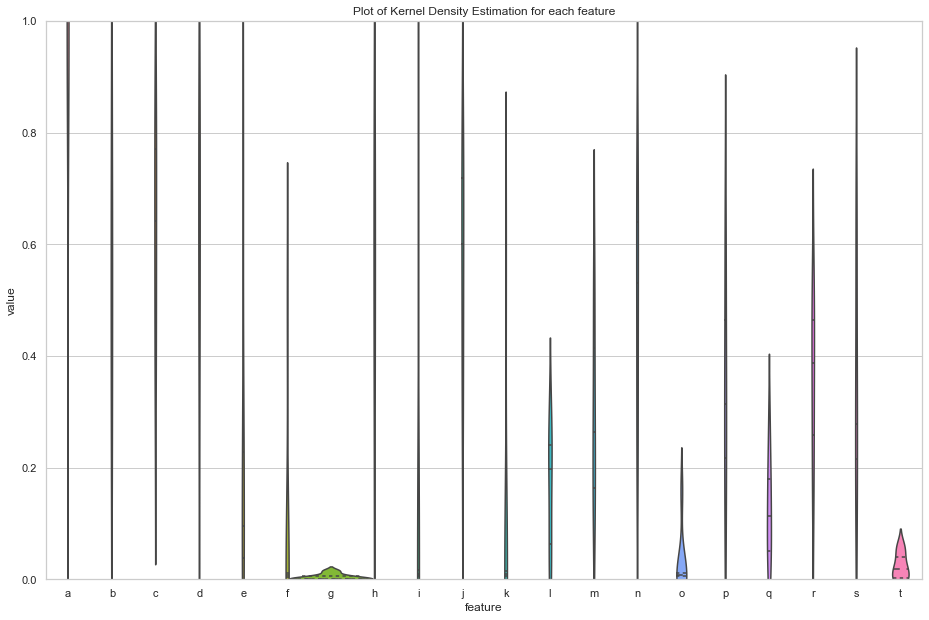

In [49]:
ax = sns.violinplot(
    x="feature",
    y="value",
    data=melted,
    split=True,
    width=1.9,
    inner="quartiles",
    cut=2,
    saturation=1,
    scale="area",
    orient="v",
)
ax.set(ylim=(0, 1))
ax.set_title("Plot of Kernel Density Estimation for each feature")

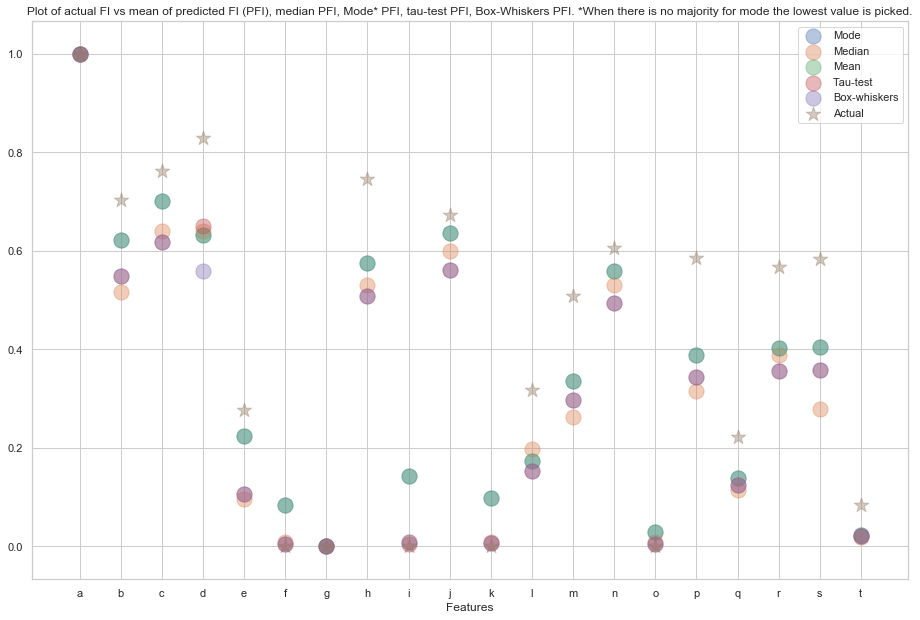

In [50]:
from scipy import stats

# plt.scatter(feature_names,rf_sv_scaled, color='red', label='Actual')
# plt.scatter(feature_names,pi_result_rf_scaled, color='red')
# plt.scatter(feature_names,gb_sv_scaled, color='red')
# plt.scatter(feature_names,pi_result_gb_scaled, color='red')
# plt.scatter(feature_names,dnn_pi_scaled, color='red')
# plt.scatter(feature_names,dnn_sv_scaled, color='red')
# plt.scatter(feature_names,dnn_ig_scaled, color='red')

plt.scatter(feature_names, total_scaled_mode, marker="o", s=230, label="Mode", alpha=0.4)
plt.scatter(feature_names, total_scaled_median, marker="o", s=230, label="Median", alpha=0.4)
plt.scatter(feature_names, total_scaled_mean, marker="o", s=230, label="Mean", alpha=0.4)
plt.scatter(feature_names, total_scaled_tau_test, marker="o", s=230, label="Tau-test", alpha=0.4)
plt.scatter(
    feature_names, total_scaled_box_whiskers, marker="o", s=230, label="Box-whiskers", alpha=0.4,
)
plt.scatter(feature_names, scaled_coef, marker="*", s=230, label="Actual", alpha=0.4)
plt.xlabel("Feature Importance")
plt.xlabel("Features")
plt.title(
    "Plot of actual FI vs mean of predicted FI (PFI), median PFI, Mode* PFI, tau-test PFI, Box-Whiskers PFI. *When there is no majority for mode the lowest value is picked."
)
plt.legend(loc="best")
plt.show()

In [51]:
# Peirce's criterion <- important because its robust statistics
# fuzzy mean
# dbscan
# some form of anomaly detection